In [2]:
%load_ext autoreload
%autoreload 2

In [2]:
from matplotlib import pyplot as plt
import Code
import sys
from glob import glob
%matplotlib inline
from os.path import join as jn
import os
from BabelViscoFDTD.H5pySimple import ReadFromH5py, SaveToH5py
import numpy as np

StaggeredFDTD_3D_CPU loaded
StaggeredFDTD_3D_CUDA NOT loaded
StaggeredFDTD_3D_OPENCL loaded
StaggeredFDTD_3D_METAL loaded
loading /Users/spichardo/miniconda3/envs/BabelJup2/lib/python3.9/site-packages/BabelViscoFDTD/tools/libBabelMetal.dylib
loaded Metal <CDLL '/Users/spichardo/miniconda3/envs/BabelJup2/lib/python3.9/site-packages/BabelViscoFDTD/tools/libBabelMetal.dylib', handle 2831af730 at 0x3058bc7c0>
mkl_fft not available


# Run all `RunPCA_FIT_ZTE_PETRA.ipynb` steps for multiple cases
We will use the location of `Target.txt` files to identify the casez

In [10]:
Ldirs=glob('**/**/Target.txt')
Ldirs.sort()
Ldirs

['DATA/ID_0068/Target.txt',
 'DATA/ID_0080/Target.txt',
 'DATA/ID_0081/Target.txt',
 'DATA/ID_0082/Target.txt',
 'DATA/ID_0083/Target.txt',
 'DATA/ID_0084/Target.txt',
 'DATA/ID_0086/Target.txt',
 'DATA/ID_0094/Target.txt',
 'DATA/ID_0095/Target.txt']

In [ ]:
for l in Ldirs:
    
    BasePath=os.path.split(l)[0]
    print('*'*60)
    print('*'*60)
    print(BasePath)
    print('*'*60)
    print('*'*60)
    

    simbnibs_path=jn(BasePath,'m2m_'+os.path.split(BasePath)[1])
    Mat4Trajectory=jn(BasePath,'Target.txt')
    ComputingDevice='M3'
    ID = 'Target'
    
    ZTE=jn(BasePath,'ZTE.nii.gz') #use always ZTE.nii.gz as file name regardless if ZTE o PETRA
    
    CTType =2 # 2 = ZTE, 3 = PETRA ; CHANGE accordingly
    
    # We instantiate the class
    P=Code.Processing(BasePath,
                          ID,
                          simbnibs_path,
                          Mat4Trajectory,
                          ComputingDevice=ComputingDevice,
                          ZTE=ZTE,
                          CTType=CTType)
    P.Run_mask_creation(bForceRecalculate=False)
    P.RunElastix('FiniteDifferenceGradientDescent',bCToMRI=True)
    P.ShowFirstPart(LineSep=120)
    P.ProcessMRI(ZTERange=[0.1,0.65])
    plt.close('all')

# Combine all ZTE/PETRA and CT data for a global PCA fitting

In [3]:
AllRes=glob('**/**/PCAFitData.h5')
AllRes.sort()
AllRes

['DATA/ID_0068/PCAFitData.h5',
 'DATA/ID_0080/PCAFitData.h5',
 'DATA/ID_0081/PCAFitData.h5',
 'DATA/ID_0082/PCAFitData.h5',
 'DATA/ID_0083/PCAFitData.h5',
 'DATA/ID_0084/PCAFitData.h5',
 'DATA/ID_0086/PCAFitData.h5',
 'DATA/ID_0094/PCAFitData.h5',
 'DATA/ID_0095/PCAFitData.h5']

In [4]:

for n,l in enumerate(AllRes):
    d=ReadFromH5py(l)
    if n==0:
        data=d['data']
        NewPCAFit=d['NewPCAFit']
    else:
        data=np.vstack((data,d['data']))
        NewPCAFit=np.vstack((NewPCAFit,d['NewPCAFit']))
    

In [5]:
# print individualized PCA fit parameters
for e in NewPCAFit:
    print(e)

[-2882.98850414  2711.5227993 ]
[-2768.68431946  2879.09153883]
[-2365.96049026  2411.82604019]
[-2696.35113285  2782.47157727]
[-2916.33938954  2680.64528247]
[-2695.04384417  2591.68172682]
[-2882.12624265  2680.91894907]
[-2895.07566613  2911.7656579 ]
[-2890.13217252  2922.43712964]


# Run PCA fitting

In [6]:
# Run
bIsPetra = False # If false, we assume ZTE

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

sc = StandardScaler()

X=sc.fit_transform(data)
X_mean = np.mean(X, axis=0)

# Apply PCA
pca = PCA(n_components=2)
pca.fit(X)


'''
We get the PCA first component to obtain a linear fitting function
'''

# First principal component
pc1 = pca.components_[0]

# Compute slope (b/a)
m = pc1[1] / pc1[0]  # slope of the first principal component

# Compute intercept
c = X_mean[1] - m * X_mean[0]

# Generate fitted line points
x_fit = np.linspace(min(X[:,0]), max(X[:,0]), 100)
y_fit = m * x_fit + c

# Print the final line equation
xf2=x_fit*sc.scale_[0]+sc.mean_[0]
yf2=y_fit*sc.scale_[1]+sc.mean_[1]

# These are the conversion factors used by default in BabelBrain
if bIsPetra:
    yf3=xf2*(-2929.6)+ 3274.9
else:
    yf3=xf2*(-2085)+ 2329.0

 New PCA fitting formula [-2842.12280745  2784.47497082]


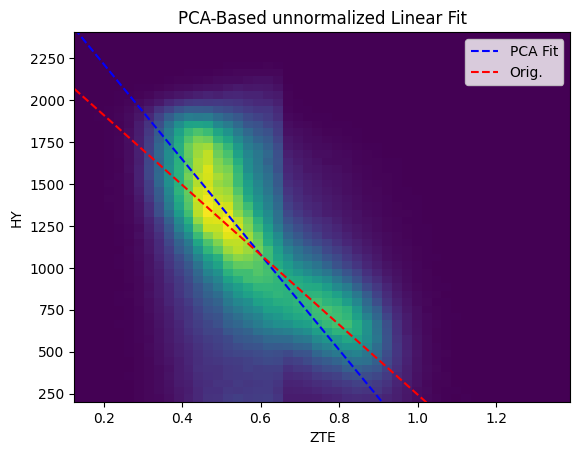

In [7]:
plt.figure()
plt.hist2d(data[:,0],data[:,1],bins=50)
plt.plot(xf2,yf2,label="PCA Fit", color='blue', linestyle='dashed')
plt.plot(xf2,yf3,label="Orig.", color='red', linestyle='dashed')
plt.xlabel("ZTE")
plt.ylabel("HY")
plt.legend()
plt.title("PCA-Based unnormalized Linear Fit")


'''
We convert from PCA normalized condition fitting to un-normalized
This is the new fitting formula for ZTE/PETRA to pseudo CT
'''
lin_fit=np.polyfit(xf2,yf2,1)
print(' New PCA fitting formula', lin_fit)